In [79]:
import pandas as pd
from bonsai.ensemble.paloboost import PaloBoost
from bonsai.ensemble.paloforest import PaloForest

In [3]:
df = pd.read_pickle('../../data/processed/ictcf.pkl')

In [4]:
df

Input                                                                \
      Clinical                                                                 
     Value_5NT Value_AFU Value_ALB Value_ALG Value_ALP Value_ALT Value_APOA1   
0          0.6       NaN    -0.015      -0.6  0.109091  1.657143         NaN   
1          0.9       NaN     0.295       0.2 -0.036364  1.285714         NaN   
2          NaN       NaN    -0.250      -1.2  0.036364  1.542857         NaN   
3          0.8       NaN    -0.165      -0.6  0.236364  0.857143         NaN   
4          NaN       NaN       NaN       NaN       NaN       NaN         NaN   
...        ...       ...       ...       ...       ...       ...         ...   
1516       0.9       NaN    -0.045      -0.8  0.172727  2.600000         NaN   
1517       NaN       NaN       NaN       NaN       NaN       NaN         NaN   
1518       NaN       NaN       NaN       NaN       NaN       NaN         NaN   
1519       NaN       NaN       NaN       NaN       NaN       NaN         NaN   
1520       NaN       NaN       NaN       NaN       NaN       NaN         NaN   

                                      ...                                \
                                      ...         Visual                  
     Value_APOB Value_APTT Value_ASO  ... vis_feature_50 vis_feature_51   
0           NaN   0.677419       NaN  ...       1.495522       1.407101   
1           NaN   1.012903       NaN  ...       5.180016       5.079040   
2           NaN        NaN       NaN  ...       0.097889       0.061765   
3           NaN   0.696774       NaN  ...       0.958515       0.878605   
4           NaN        NaN       NaN  ...      -0.102868      -0.146057   
...         ...        ...       ...  ...            ...            ...   
1516        NaN   0.935484       NaN  ...       2.803237       2.507623   
1517        NaN        NaN       NaN  ...      -0.630937      -0.590748   
1518        NaN        NaN       NaN  ...      -0.516554      -0.496094   
1519        NaN        NaN       NaN  ...       0.124466       0.111390   
1520        NaN        NaN       NaN  ...       1.869963       1.792377   

                                                                  \
                                                                   
     vis_feature_52 vis_feature_53 vis_feature_54 vis_feature_55   
0          0.086921       0.072483       0.069505       0.051657   
1          3.516342       3.404648       3.442693       3.337378   
2         -0.239709      -0.255159      -0.260668      -0.277846   
3          0.145058       0.107863       0.133092       0.092496   
4         -0.608026      -0.617320      -0.617773      -0.630355   
...             ...            ...            ...            ...   
1516       0.919673       0.772426       0.912312       0.760904   
1517      -0.850672      -0.832764      -0.867031      -0.852193   
1518      -0.825329      -0.808753      -0.834399      -0.821405   
1519      -0.201476      -0.209360      -0.209015      -0.221224   
1520       1.302997       7.887997       1.169276       0.061628   

                                                                  
                                                                  
     vis_feature_56 vis_feature_57 vis_feature_58 vis_feature_59  
0         -0.409348      -0.414904      -0.435154      -0.488452  
1          1.271466       1.221740       1.255130       1.191330  
2         -0.393225      -0.406874      -0.414642      -0.454006  
3         -0.333626      -0.353214      -0.352350      -0.419885  
4         -0.611461      -0.623873      -0.624798      -0.681182  
...             ...            ...            ...            ...  
1516      -0.141144      -0.196170      -0.162558      -0.266687  
1517      -0.569649      -0.572261      -0.597436      -0.649602  
1518      -0.645694      -0.645272      -0.667305      -0.714351  
1519      -0.407458      -0.420308      -0.431136      -0.493907  
1520      -4.

In [259]:
df_train = df[df.Meta.Metadata_Hospital != 'Union']
df_test = df[df.Meta.Metadata_Hospital == 'Union']

In [260]:
import numpy as np
import re
def prepare(X):
    for col in X.select_dtypes(include=['category']):
        X[col] = X[col].cat.codes
        X.loc[X[col] < 0, col] = np.nan

    X.columns = [re.sub(r'[^0-9a-zA-Z_-]+ ', '', '_'.join(col).strip()) for col in X.columns.values]
    return X

X_train, y_train = df_train.Input.Clinical, df_train.Target.Metadata_PCR
X_test, y_test = df_test.Input.Clinical, df_test.Target.Metadata_PCR
X_train = prepare(X_train)
X_test = prepare(X_test)

In [264]:
# %%timeit
from bonsai.ensemble.randomforests import RandomForests
from sklearn.ensemble import BaggingClassifier
from bonsai.base.friedmantree import FriedmanTree
from bonsai.ensemble.gbm import GBM
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import StandardScaler
from lightgbm.sklearn import LGBMClassifier
# boost = RandomForests(C45Tree, {})
# boost = BaggingClassifier(C45Tree())
# boost = GBM(distribution='')
# boost = SVC()
boost = make_pipeline(
    SimpleImputer(), 
    MLPClassifier(hidden_layer_sizes=(5, ))
)
# boost = PaloBoost(distribution='gaussian', max_depth=2)
# boost = make_pipeline(
#     SimpleImputer(), 
#     StandardScaler(), 
#     BayesianRidge()
# )
# boost = BaggingClassifier(LGBMClassifier(n_jobs=-1, boosting_type='gbdt', n_estimators=10), n_estimators=4000, max_samples=1.0, bootstrap_features=False)
boost = LGBMClassifier(n_jobs=-1)
boost.fit(X_train.values, (y_train == 'Positive').values)

LGBMClassifier()

In [265]:
from sklearn.metrics import accuracy_score
accuracy_score((y_test == 'Positive').values, np.round(boost.predict(X_test.values)))

0.5657193605683837

In [266]:
from sklearn.metrics import roc_auc_score
roc_auc_score((y_test == 'Positive').values, boost.predict_proba(X_test.values)[:, 1])

0.6733189016093886

In [307]:
import shap
top_feat = np.argsort(np.abs(shap.TreeExplainer(LGBMClassifier(n_jobs=-1).fit(X_train.values, (y_train == 'Positive').values))(X_test.values)[:, :, 1].values).mean(axis=0))[-10:]

<AxesSubplot:>

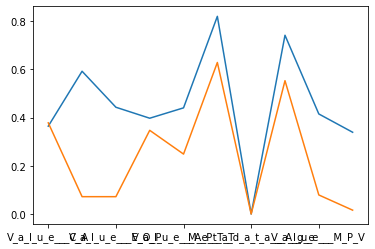

In [308]:
(X_train.iloc[:, top_feat].isna().sum()/X_train.shape[0]).plot()
(X_test.iloc[:, top_feat].isna().sum()/X_test.shape[0]).plot()

In [291]:
(df_train_r.isna().sum()/df_train_r.shape[0] - df_test_r.isna().sum()/df_test_r.shape[0]).abs().mean()

0.01631334034368707

<AxesSubplot:>

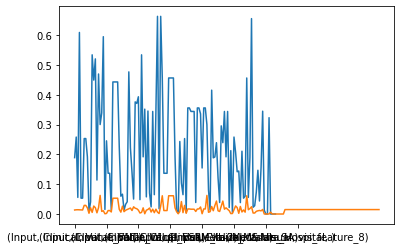

In [289]:
(X_train.isna().sum()/X_train.shape[0] - X_test.isna().sum()/X_test.shape[0]).abs().plot()
(df_train_r.isna().sum()/df_train_r.shape[0] - df_test_r.isna().sum()/df_test_r.shape[0]).abs().plot()

In [286]:
from sklearn.model_selection import train_test_split
df_train_r, df_test_r = train_test_split(df, test_size=0.2, shuffle=True)

<AxesSubplot:>

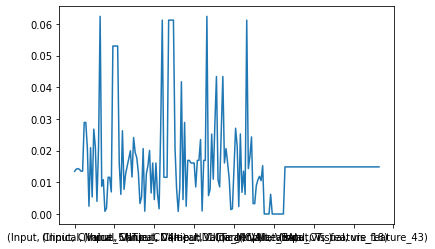

In [288]:
(df_train_r.isna().sum()/df_train_r.shape[0] - df_test_r.isna().sum()/df_test_r.shape[0]).abs().plot()

In [262]:
from sklearn.metrics import accuracy_score
accuracy_score((y_test == 'Positive').values, np.round(boost.predict(X_test.values)))

0.5452930728241563

In [263]:
from sklearn.metrics import roc_auc_score
roc_auc_score((y_test == 'Positive').values, boost.predict_proba(X_test.values)[:, 1])

0.6965604391264859

In [254]:
# %%timeit
from bonsai.ensemble.randomforests import RandomForests
from sklearn.ensemble import BaggingClassifier
from bonsai.base.friedmantree import FriedmanTree
from bonsai.ensemble.gbm import GBM
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import StandardScaler
from lightgbm.sklearn import LGBMClassifier
# boost = RandomForests(C45Tree, {})
# boost = BaggingClassifier(C45Tree())
# boost = GBM(distribution='')
# boost = SVC()
boost = make_pipeline(
    SimpleImputer(), 
    MLPClassifier(hidden_layer_sizes=(5, ))
)
# boost = PaloBoost(distribution='gaussian', max_depth=2)
boost = PaloForest()
# boost = make_pipeline(
#     SimpleImputer(), 
#     StandardScaler(), 
#     BayesianRidge()
# )
# boost = BaggingClassifier(LGBMClassifier(n_jobs=-1, boosting_type='gbdt', n_estimators=10), n_estimators=4000, max_samples=1.0, bootstrap_features=False)
boost.fit(X_train.values, (y_train == 'Positive').values)

c:\users\roel\.virtualenvs\diagcovid-ckc2berq\lib\site-packages\numpy\lib\nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


In [256]:
from sklearn.metrics import accuracy_score
accuracy_score((y_test == 'Positive').values, np.round(boost.predict(X_test.values)))

0.6227848101265823

In [258]:
from sklearn.metrics import roc_auc_score
roc_auc_score((y_test == 'Positive').values, boost.predict_proba(X_test.values))

0.6448397386427948

In [13]:
from palobst import PaloBst
boost = PaloBst()
boost.fit(X_train.values, (y_train == 'Positive').values)

SystemError: CPUDispatcher(<function grow at 0x0000028FFD3BCEE8>) returned a result with an error set

In [106]:
import optuna
from sklearn.model_selection import cross_val_score, StratifiedKFold

cv = StratifiedKFold()

# 1. Define an objective function to be maximized.
def objective(trial):
    # 2. Suggest values for the hyperparameters using a trial object.
    params = {
        'distribution': trial.suggest_categorical('distribution', ['gaussian', 'bernoulli', '']), 
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-10, 0.5), 
        'subsample': trial.suggest_uniform('subsample', 0.1, 1.0), 
        'subsample_splts': trial.suggest_uniform('subsample_splits', 0.5, 1.0), 
        'max_depth': trial.suggest_int('max_depth', 1, 12), 
        'n_estimators': trial.suggest_int('n_estimators', 3, 280)
    }
    
    clf = PaloBoost(n_jobs=8, **params)
#     def get_params(deep=False):
#         return params
#     clf.get_params = get_params
#     print(clf.get_params())
    
#     clf.fit(X_train.values, (y_train == 'Positive').values)
    X, y =  X_train.values, (y_train == 'Positive').values
    scores = []
    for train_ind, test_ind in cv.split(X, y):
        X_train_new, y_train_new = X[train_ind], y[train_ind]
        X_val, y_val = X[test_ind], y[test_ind]
        
        clf.fit(X_train_new, y_train_new)
        scores.append(roc_auc_score(y_val, (clf.predict_proba(X_val))))
        
#     cross_val_score(clf, X_train.values, (y_train == 'Positive').values, scoring='roc_auc')
    
    return np.mean(scores)

In [107]:
# 3. Create a study object and optimize the objective function.
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2021-07-05 16:03:18,378] A new study created in memory with name: no-name-1b628fad-9c45-4bec-a942-9f850bb4e3d7
c:\users\roel\.virtualenvs\diagcovid-ckc2berq\lib\site-packages\numpy\lib\nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
c:\users\roel\.virtualenvs\diagcovid-ckc2berq\lib\site-packages\numpy\lib\nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
c:\users\roel\.virtualenvs\diagcovid-ckc2berq\lib\site-packages\numpy\lib\nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
c:\users\roel\.virtualenvs\diagcovid-ckc2berq\lib\site-packages\numpy\lib\nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
c:\users\roel\.virtualenvs\diagcovid-ckc2berq\lib\site-packages\numpy\lib\nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
[I 2021-07-05 16:03:37,889

ValueError: y should be a 1d array, got an array of shape (226, 2) instead.

In [78]:
from sklearn.metrics import accuracy_score, roc_auc_score
accuracy_score(y_test == 'Positive', np.round(boost.predict(X_test.values)))

0.7873417721518987

In [79]:
roc_auc_score(y_test == 'Positive', (boost.predict_proba(X_test.values)))

0.840999125379431

In [28]:
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np
from sklearn.datasets import load_breast_cancer
from lightgbm.sklearn import LGBMClassifier
from bonsai.base.c45tree import C45Tree
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List, Any

In [29]:
from numba import njit, prange
@njit(fastmath=True)
def gini_impurity(X: np.ndarray):
    result = 0
    classes = np.unique(X[:, -1])
    for c in classes:
        result += ((X[:, -1]==c).sum()/X.shape[0])**2
    return 1 - result

@njit(fastmath=True)
def gini_index(Xs: List[np.ndarray]):
#     total_size = np.sum(np.array([X.shape[0] for X in Xs]))
    total_size = 0
    for X in Xs:
        total_size += X.shape[0]
    if total_size == 0:
        return 1
    result = 0
    for X in Xs:
        result += X.shape[0]/total_size * gini_impurity(X)
    return result
#     return np.sum([X.shape[0]/total_size * gini_impurity(X) for X in Xs])

In [30]:
@njit
def split_data(X: np.ndarray, feature_index: int, split_value: float):
    is_na = np.isnan(X[:, feature_index])
    left = X[(X[:, feature_index] < split_value) | is_na]
    right = X[(X[:, feature_index] >= split_value) | is_na]
    return left, right

In [31]:
@njit
def generate_split_points(X: np.ndarray, feature_index: int):
    splits = np.sort(X[:, feature_index])
    return set(splits[~np.isnan(splits)])

In [32]:
from dataclasses import dataclass
from typing import Union

@dataclass
class Leaf:
    value: int
    n_samples: int

@dataclass
class Tree:
    left: Union['Tree', Leaf]
    right: Union['Tree', Leaf]
    split_feature: int
    split_value: float
    n_samples: int

In [33]:
@njit(fastmath=True)
def get_split(X: np.ndarray):
    best_gini, best_feature, best_split, best_groups = np.inf, None, None, None
    for feature_index in range(X.shape[1]-1):
        for split_value in generate_split_points(X, feature_index):
            groups = split_data(X, feature_index, split_value)
            gini = gini_index(groups)
            if gini < best_gini:
                best_gini = gini
                best_feature = feature_index
                best_split = split_value
                best_groups = groups
    current_gini = gini_impurity(X)
    if current_gini < best_gini:
        return 0, 0, 0, (None, None)
    return best_feature, best_split, best_gini, best_groups

In [34]:
# @njit
# def most_frequent(a: np.ndarray):
#     values, counts = np.unique(a, return_counts=True)
#     ind = np.argmax(counts)
#     return values[ind]

@njit
def most_frequent(x):
    return np.argmax(np.bincount(x.astype(np.int32)))

In [35]:
def decision_tree(X: np.ndarray, last_gini=None):
    best_feature, best_split, best_gini, (left, right) = get_split(X)
#     print(best_gini)
#     print(left is None)
    if left is None or last_gini == best_gini:
        return Leaf(most_frequent(X[:, -1]), X.shape[0])
#     print(len(np.unique(left[:, -1])))
#     print(np.unique(left[:, -1]))
#     print(len(left))
    if len(np.unique(left[:, -1])) == 1:
#         print('left leaf')
        left_tree = Leaf(most_frequent(left[:, -1]), left.shape[0])
    elif len(np.unique(left[:, -1])) == 0:
#         print('left leaf')
        left_tree = Leaf(most_frequent(X[:, -1]), 1)
    else:
#         print('recurse')
        left_tree = decision_tree(left, last_gini=best_gini)
    
#     print(len(np.unique(right[:, -1])))
#     print(np.unique(right[:, -1]))
#     print(len(right))
#     print()
    if len(np.unique(right[:, -1])) == 1:
        right_tree = Leaf(most_frequent(right[:, -1]), right.shape[0])
    elif len(np.unique(right[:, -1])) == 0:
        right_tree = Leaf(most_frequent(X[:, -1]), 1)
    else:
#         print('right recurse')
#         print(best_split)
#         print(best_feature)
#         print(np.unique(right[best_feature]))
#         print(gini_index([left, right]))
#         print(gini_impurity(right))
        right_tree = decision_tree(right, last_gini=best_gini)
    
    return Tree(left_tree, right_tree, best_feature, best_split, X.shape[0])

In [36]:
def predict(tree: Union[Tree, Leaf], sample: np.ndarray):
    if isinstance(tree, Leaf):
        return tree.value
    
    if sample[tree.split_feature] < tree.split_value:
        return predict(tree.left, sample)
    elif np.isnan(sample[tree.split_feature]):
        total_samples = tree.left.n_samples + tree.right.n_samples
        return (predict(tree.left, sample)*tree.left.n_samples + predict(tree.right, sample)*tree.right.n_samples)/total_samples
    
    return predict(tree.right, sample)

In [37]:
class DecisionTree(BaseEstimator, ClassifierMixin):
    def __init__(self, random_state=0):
        pass
    
    def fit(self, data, labels):
        self.tree = decision_tree(np.concatenate([data, labels[:, None]], axis=1))
    
    def predict(self, data):
        return np.array([np.round(predict(self.tree, data[i, :])) for i in range(data.shape[0])])

In [38]:
from scipy.stats import mode
class RandomForest(BaseEstimator, ClassifierMixin):
    def __init__(self, n_trees=10):
        self.n_trees = n_trees
        
    def _boostrap_data(self, data):
        return data[np.random.choice(data.shape[0], size=data.shape[0]), :]
    
    def fit(self, data, labels):
        self.trees = [decision_tree(self._boostrap_data(np.concatenate([data, labels[:, None]], axis=1))) 
                      for i in range(self.n_trees)]
        
    def _predict_single(self, row):
        return mode([np.round(predict(t, row)) for t in self.trees]).mode
    
    def predict(self, data):
        return np.array([self._predict_single(data[i, :]) for i in range(data.shape[0])])

In [271]:
dt = RandomForest(n_trees=100)
# dt = DecisionTree()
dt.fit(np.array(X_train.values, order='C'), (y_train == 'Positive').values.astype(np.int32))

In [273]:
dt.score(np.array(X_test.values, order='C'), (y_test == 'Positive').values.astype(np.int32))

0.5417406749555951

In [69]:
from sklearn.tree import DecisionTreeClassifier
from lightgbm.sklearn import LGBMClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
t = make_pipeline(
#     SimpleImputer(), 
    LGBMClassifier()
)
t.fit(np.array(X_train.values, order='C'), (y_train == 'Positive').values.astype(np.int32))

Pipeline(steps=[('lgbmclassifier', LGBMClassifier())])

In [70]:
t.score(np.array(X_test.values, order='C'), (y_test == 'Positive').values.astype(np.int32))

0.5670886075949367

In [71]:
from sklearn.metrics import roc_auc_score
roc_auc_score((y_test == 'Positive').values.astype(np.int32), t.predict_proba(np.array(X_test.values, order='C'))[:, 1])

0.6689303904923599

In [61]:
np.isfortran((y_train == 'Positive').values.astype(np.int32))

False

In [63]:
np.isfortran(np.array(X_train.values, order='c'))

False